<a href="https://colab.research.google.com/github/yiyinglai/Pneumonia/blob/master/stage2_shuffled_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# %tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import interp
import numpy as np
import tqdm
import math
import cv2
import os
# ! pip install git+https://github.com/divamgupta/image-segmentation-keras.git

Using TensorFlow backend.


In [0]:
!cp -r "/content/gdrive/My Drive/stage2_segmented" /content/

In [0]:
# GENERATORS FOR model
from sklearn.utils.class_weight import compute_class_weight

train_directory = '/content/stage2_segmented/train'
validation_directory = '/content/stage2_segmented/validation'
test_directory = '/content/stage2_segmented/test'
CLASSES = ['bacteria', 'virus']
# train image generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(299, 299),
                                                    batch_size=16,
                                                    shuffle=True,
                                                    classes=CLASSES)
unique, train_counts = np.unique(train_generator.labels, return_counts=True)
train_size = train_counts.sum()
# validation image generator
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=10,
                                        horizontal_flip=True,
                                        vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(299, 299),
                                                    batch_size=16,
                                                    shuffle=True,
                                                    classes=CLASSES)
unique, validation_counts = np.unique(validation_generator.labels, return_counts=True)
validation_size = validation_counts.sum()
# test image generator
test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=(299, 299),
                                                  batch_size=16,
                                                  shuffle=False,
                                                  classes=CLASSES)
unique, test_counts = np.unique(test_generator.labels, return_counts=True)
test_size = test_counts.sum()

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

train_BACTERIAL = len(os.listdir(os.path.join(train_directory, CLASSES[0])))
train_VIRAL = len(os.listdir(os.path.join(train_directory, CLASSES[1])))
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
print(class_weights)
print([train_BACTERIAL, train_VIRAL])

Found 2987 images belonging to 2 classes.
Found 642 images belonging to 2 classes.
Found 641 images belonging to 2 classes.
{'bacteria': 0, 'virus': 1}
{'bacteria': 0, 'virus': 1}
{'bacteria': 0, 'virus': 1}
[0.76786632 1.43330134]
[1945, 1042]


In [0]:
# LOAD PRETRAINED MODEL InceptionV3
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
inceptionv3 = InceptionV3(weights='imagenet', include_top=True)














96116736/96112376 [==============================] - 4s 0us/step


In [0]:
# BUILD NEW CLASSIFICATION MODEL BASED ON inceptionv3
import tensorflow
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Input, Dense, Lambda
from keras import metrics
from keras.backend import resize_images
import cv2

y = inceptionv3.layers[-2].output
outputs = Dense(2, activation='softmax')(y)

# this is the model we will train
model2 = Model(inputs=inceptionv3.inputs, outputs=outputs)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in inceptionv3.layers:
  layer.trainable = False
for layer in model2.layers:
  layer.trainable = True

rmsprop = RMSprop()
adam = Adam()
# compile the model (should be done *after* setting layers to non-trainable)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()
# metrics.binary_accuracy,binary_crossentropy



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

In [0]:
# TRAIN model
from math import ceil
from keras.callbacks import ModelCheckpoint

# train the model on the new data for a few epochs
steps_per_epoch = ceil(train_size/16)
validation_steps = ceil(validation_size/16)

history = model2.fit_generator(train_generator, epochs=30, verbose=1,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              validation_freq=1,
                              class_weight=class_weights)

Epoch 1/30
187/187 [==============================] - 104s 554ms/step - loss: 0.4962 - acc: 0.7732 - val_loss: 0.5571 - val_acc: 0.7352
Epoch 2/30
187/187 [==============================] - 99s 528ms/step - loss: 0.4970 - acc: 0.7718 - val_loss: 0.5686 - val_acc: 0.7383
Epoch 3/30
187/187 [==============================] - 99s 528ms/step - loss: 0.4944 - acc: 0.7687 - val_loss: 0.8753 - val_acc: 0.5109
Epoch 4/30
187/187 [==============================] - 98s 523ms/step - loss: 0.4966 - acc: 0.7681 - val_loss: 0.5377 - val_acc: 0.7523
Epoch 5/30
187/187 [==============================] - 98s 526ms/step - loss: 0.4955 - acc: 0.7756 - val_loss: 0.6463 - val_acc: 0.7009
Epoch 6/30
187/187 [==============================] - 98s 522ms/step - loss: 0.4848 - acc: 0.7741 - val_loss: 0.5396 - val_acc: 0.7321
Epoch 7/30
187/187 [==============================] - 98s 522ms/step - loss: 0.4912 - acc: 0.7724 - val_loss: 0.5511 - val_acc: 0.7445
Epoch 8/30
187/187 [==============================] - 

In [0]:
import json
import pandas as pd
with open('/content/gdrive/My Drive/model2/history_model2.json', 'r') as f1:
    data1 = json.load(f1)
history1= pd.DataFrame(data1)
with open('/content/gdrive/My Drive/model2/history_model2_2.json', 'r') as f2:
    data2 = json.load(f2)
history2= pd.DataFrame(data2)

In [0]:
history2=history2.reset_index(drop=True)
vertical_stack = pd.concat([history1, history2], ignore_index=True)

In [0]:
print(vertical_stack)

    val_loss   val_acc      loss       acc
0   5.623759  0.651090  0.645611  0.667894
1   1.744850  0.436137  0.607094  0.687646
2   0.575220  0.713396  0.599776  0.694677
3   1.465359  0.651090  0.585411  0.708738
4   0.642144  0.680685  0.579134  0.708403
..       ...       ...       ...       ...
70  0.573734  0.721184  0.441308  0.795782
71  0.511189  0.767913  0.449001  0.799464
72  0.672413  0.685358  0.443011  0.797790
73  0.747744  0.732087  0.442647  0.799464
74  0.588801  0.694704  0.445447  0.791764

[75 rows x 4 columns]


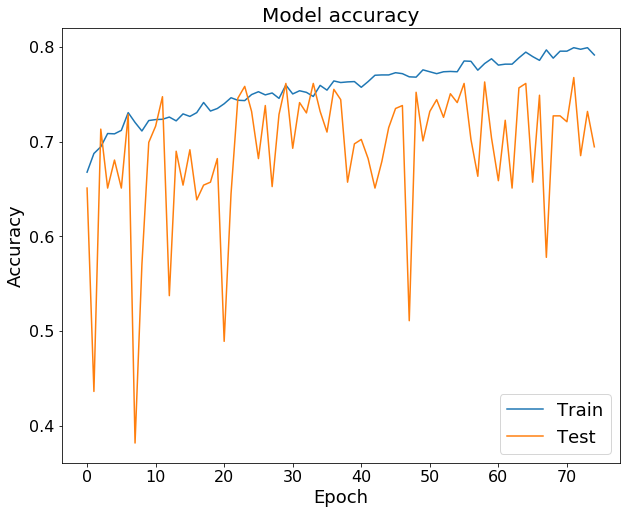

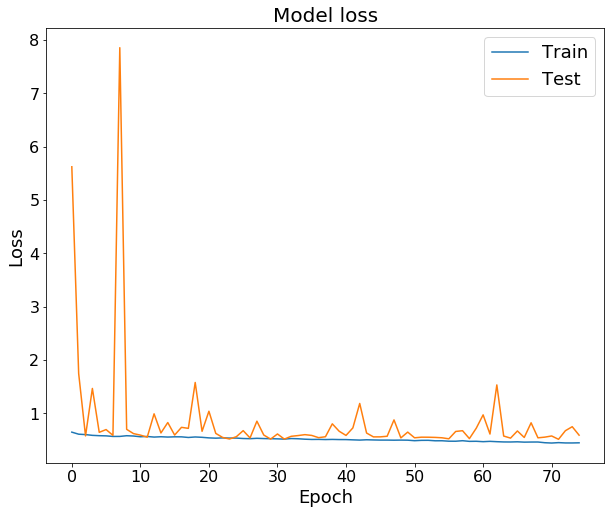

In [0]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10, 8))
plt.plot(vertical_stack.acc)
plt.plot(vertical_stack.val_acc)
plt.title('Model accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(['Train', 'Test'], loc='lower right',fontsize=18)
plt.show()
fig.savefig('/content/gdrive/My Drive/model2/history_accuracy3.jpeg')

# Plot training & validation loss values
fig = plt.figure(figsize=(10, 8))
plt.plot(vertical_stack.loss)
plt.plot(vertical_stack.val_loss)
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(['Train', 'Test'], loc='upper right',fontsize=18)
plt.show()
fig.savefig('/content/gdrive/My Drive/model2/history_loss3.jpeg')

In [0]:
model2.save('/content/gdrive/My Drive/model2/model2_2.h5')

In [0]:
results = model2.evaluate_generator(test_generator)
print(results)

[0.5366323654904567, 0.7238689547581904]


In [0]:
pred_scores = model2.predict(test_generator)
y_pred = np.argmax(pred_scores,axis=1)
print(y_pred)

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1
 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0
 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0
 0 1 0 1 1 0 0 0 0 1 0 0 

In [0]:
y_true = test_generator.labels
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
cls_report_print = classification_report(y_true, y_pred, target_names=CLASSES)

cls_report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)

print("\n\n")
print("-"*90)
# print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    bacteria       0.79      0.75      0.77       417
       virus       0.57      0.63      0.60       224

    accuracy                           0.71       641
   macro avg       0.68      0.69      0.68       641
weighted avg       0.71      0.71      0.71       641

------------------------------------------------------------------------------------------
